# Twin neural network para UPLIFT

## I - Introduccion

Este experimento tiene como objetivo principal desarrollar e implementar el framework propuesto por XXX en su paper ZZZ para el desarrollo de una red neural que fuese capaz de obtimizar el rendimiento de la aplicacion de UPLIFT.

Acá se usa el dataset (con un preprocesamiento hecho) que esta compuesto por los resultados de una campaña de marketing desarrollada durante el año 2021 a una población aproximada de 5.000 personas.

La motivación de este experimento es sentar las bases de un código inicial que pueda ser usado por otras personas y que además, se preste la capacidad de contribución con el fin del desarrollo de una mejora continua del mismo.

Sobre UPLIFT y este experimento hay que tener en cuenta:



1.   **UPLIFT**: en este experimento el enfoque principal de la aplicacion de uplift es para campañas de marketing, con el fin de obtimizar el profit de la misma, a sabiendas que uplift no solo puede ser usado para campañas de marketing, tambien puede ser usado para investigacion en el area de la salud, campañas politicas y cualquier otro estudio donde se busque identificar la parte de una población mas proprensa a responder a un estimulo o alguna otra intervención

2.   **Grupos**: como si se tratara de una prueba **A y B** uplift implementa una separacion de la población en dos grupos, un grupo de control y un grupo de tratamiento. El grupo de tratamiento es aquel que recibe el estimulo, mientras que el grupo de control sirve para comparacion, la diferencia entre estos, es la base fundamental de uplift

3.   **Objetivo**: se busca implementar el framework propuesto por XXX y ZZZ y de esta forma obtener los resultados para posteriormente compararlos con otros experimentos realizados

4.   **Metodologia**: se experimenta con un datasets generado con el unico proposito de llevar a cabo esta investigacion, el mismo durante su desarrollo se separo en dos grupos donde *group ∈ { 1, 0 }* (segun nuestro dataset) y representa la pertenencia o no al grupo de tratamiento. Para este desarrollo se usa la libreria Keras que servirá para la creación de la red neuronal

5.   **Motiviacion de uplift**: a diferencia de los metodos tradicionales de clasificacion o regresion, uplift no tiene como objetivo principal determinar si una persona respondera o no de forma positiva a una campaña de marketing, en lugar de eso se busca evaluar cuan persuadiable es este con el fin de aumentar el rendimiento de la campaña y evitar así enfocarse en otros grupos de personas que pueden ser una compra segura indiferentemente de si recibieron un estimulo, asi como aquellos que son caso perdido o aquellos que simplemente tendran una respuesta negativa al estimulo

6.   **Resultados**: 






## II - Work Flow del experimento

# 1- Setup

In [ ]:
#librerias necesarias para el proyecto
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#!pip install q tensorflow==2.5.1
#!pip install q keras==2.4.2

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf
from keras.layers.core import Dense, Dropout, Flatten 
from sklearn.model_selection import train_test_split
#!pip install q keras==1.2.2
import keras
from keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from keras.losses import mean_squared_error,binary_crossentropy
from tensorflow.keras.layers import Dense


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from collections import Counter
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV

!pip install pip install scikit-uplift
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.viz import plot_uplift_by_percentile
from sklift.metrics import qini_auc_score
import math
#from tensorflow import keras as kk
import os
import random




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 KB 2.9 MB/s eta 0:00:00


In [ ]:
#importamos el dataframe con un preprocesamiento inicial hecho (este preprocesamiento y el dataset original se puede encontrar en XXX)
df = pd.read_csv('dataframe.csv')





In [ ]:
##clase utilidades, y configuraciones iniciales
class utils:
  def __init__(self , dataset):
    self.dataset = dataset
    self.balance( self.dataset )
    self.alpha=0.05
    self.optimizer="rmsprop"
    self.reg = 0.01
    self.batch_size = 96
    self.epochs = 45
    self.input_dim = 29
    self.shape0 = (29,)
    self.shape1 = 1
    self.test_size =0.3
    self.ratio_balance='auto'
    self.set_transformed_outcome( self.dataset )
  ## es requerido q el total de observaciones de T sea igual en 1 y en 0
  def balance(self , dataset   ):
    self.dataset = dataset
    qty=0
    if( len(self.dataset[ self.dataset['group'] ==1 ]) > len(self.dataset[ self.dataset['group'] ==0 ]) ):
      delete_in_group = 1
      qty = len(self.dataset[ self.dataset['group'] ==1 ]) - len(self.dataset[ self.dataset['group'] ==0 ])
    elif( len(self.dataset[ self.dataset['group'] == 0 ]) > len(self.dataset[ self.dataset['group'] ==1 ]) ):
      delete_in_group = 0
      qty = len(self.dataset[ self.dataset['group'] ==0 ]) - len(self.dataset[ self.dataset['group'] ==1 ])
    else:
      delete_in_group = -1
    if( delete_in_group!=-1 ):
      set_to_join_1 = self.dataset[ self.dataset['group'] != delete_in_group  ]
      set_to_join_2 = self.dataset[ self.dataset['group'] == delete_in_group  ]
      set_to_join_2_0 = set_to_join_2[ set_to_join_2['buy_campaing'] == 0  ]
      set_to_join_2_1 = set_to_join_2[ set_to_join_2['buy_campaing'] == 1  ]

      set_to_delete = set_to_join_2_0.iloc[0:len(set_to_join_2_0)-qty,:]

      df = pd.DataFrame(data=set_to_delete)
      self.dataset = pd.concat([set_to_join_1, set_to_delete, set_to_join_2_1])
      return self.dataset
  
  def _replaceitem( self, x):
    if( x >= 0.5 ):
      return 1
    return 0

  def clean_list(  self,list  ):
    new_list = []
    for index_ in range(len(list)):
      j = list[index_]
      new_list.append( (j[0]) )
    return new_list
      

  #aplicamos la transformacion de clases
  def set_transformed_outcome( self , dataset_  ):
    self.dataset = dataset_
    self.dataset["z"] = 0;
    self.dataset.loc[ (self.dataset['buy_campaing'] == 1) & (self.dataset['group'] == 1) , 'z' ] = 2
    self.dataset.loc[ (self.dataset['buy_campaing'] == 1) & (self.dataset['group'] == 0) , 'z' ] = -2
    return self.dataset

  #esta red tiene un estructura similar a la que se implementara en la red siamesa, el unico proposito de esta es analizar los metodos de balanceo
  def build_rn( self, optimizer = '' , dropout_rate=0.0  , activation = "relu" , neurons= 15):
    if( optimizer ==""):
      optimizer = self.optimizer    
    classifier = Sequential()
    classifier.add(Dense( neurons , activation = activation, input_dim = utils.input_dim  , input_shape=utils.shape0 , name="layer1") )
    classifier.add(Dropout(dropout_rate))
    classifier.add(Dense(units = 10, activation = "relu", name="layer2"))
    classifier.add(Dropout(dropout_rate))
    classifier.add(Dense(units = 1, kernel_initializer = "uniform",  activation = "sigmoid", name="layer3"))

    classifier.compile( optimizer= optimizer, loss="binary_crossentropy" , metrics=["accuracy"],
                        )
    
    return classifier


  







  ## calcular los pesos
  '''def get_weights( self, y_train ):
    weights_ = class_weight.compute_class_weight(
                                                 np.unique(y_train),
                                                 y_train)
    weights_ = { 0 : weights_[0] , 1:weights_[1]  }
    return weights_

  ##para generar los pares'''
  def make_pairs(self, X_test , z ):
    input1 = X_test.copy()
    input2 = X_test.copy()

    input1 = np.hstack(( input1, np.zeros(( input1.shape[0], 1), dtype= input1.dtype)))
    input2 = np.hstack(( input2, np.zeros(( input2.shape[0], 1), dtype= input2.dtype)))
    input2[:,-1] = 1 #input 0 con T = 1 
    input1[:,-1] = 0 #input 1 con T = 0 

    return [input1, input2], z

  
    



utils = utils( df )
dataset = utils.balance( df )
dataset = utils.set_transformed_outcome( dataset )
seed_value= 333
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# 2 - Exploración de los datos

Podemos observar que el dataset usado contiene un procesamiento previo, para este caso resalta el caso de las comunas que ya estan convertidas en variables dummies

In [ ]:
dataset.head(5)

,group,gender,year_birth,total_orders,total_m,total_f,total_o,regency,abandoned_cars,recupered_cars,...,maipu,nunoa,penalolen,providencia,puente alto,puerto montt,punta arenas,rancagua,buy_campaing,z
0,1,1,3,5,0,627510,0,14,0,0,...,0,0,0,0,0,0,0,0,1,2
2,1,1,3,5,0,465159,0,9,1,1,...,0,0,0,0,0,0,0,0,1,2
4,1,1,3,7,0,384755,0,21,1,0,...,0,0,0,0,0,0,0,0,1,2
5,1,1,3,2,0,375652,0,5,0,0,...,0,0,0,0,0,0,0,0,1,2
6,1,1,4,5,0,264230,101410,12,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#nos aseguramos que no existan datos nulos
display(dataset.isnull().values.any())

False

En el periodo comprendido de la campaña se obtuvo una media de respuesta de aproximadamente el 3%, esto implica que una clase 0 de la variable dependiente tendra mas peso en el clasificador. Para resolver esto necesitaremos aumentar este valor mediante tecnicas de balanceo

In [ ]:
dataset["buy_campaing"].mean()*100

3.2804459691252146

# 3-  Preprocesamiento de los datos

En vista de que este dataset ya tiene un preprocesamiento hecho, solo nos concentraremos en realizar el balanceo de la clase minoritaria ( ***y = 1*** ) para mejorar el rendimiento de la red

In [ ]:
#usamos esta funcion para mostrar en barras la diferencia entre cada clase
def show_dif( data , title =""):
  LABELS = ["No compra","Compra"]
  count_classes = pd.value_counts(data, sort = True)
  count_classes.plot(kind = 'bar', rot=0)
  plt.xticks(range(2), LABELS)
  plt.title("Frecuencia de clases - "+title)
  plt.xlabel("Resultado")
  plt.ylabel("Observaciones");

#esta funcion servira para obtener las metricas de rendimiento de la red en base al metodo de balanceo actual
def show_results(y_test, pred_y , title ="Confusion matrix" ):
    print("*****************"+title+"************************")
    LABELS = ["No compra","Compra"]
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title( title )
    plt.ylabel('Clase real')
    plt.xlabel('Clase predicha')
    plt.show()
    show_dif( pred_y , title )
    print(classification_report(y_test, pred_y))
    return classification_report(y_test, pred_y , output_dict=True)



Acá podemos ver la amplia diferencia que existe entre las dos clases

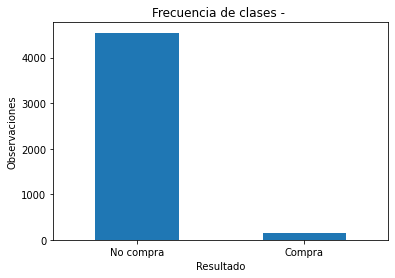

In [ ]:
show_dif( df['buy_campaing'] )

Antes de comenzar a experimentar con los metodos de balanceo, generamos un conjunto de prueba y de testing auxiliares que serviran para implementar el experimento de cada metodo

In [ ]:
df_ = dataset.copy()
y_aux = df_['buy_campaing'].values
X_aux = df_.drop('buy_campaing', axis=1)
print(y_aux)
print(X_aux)
X_train_aux_, X_test_aux_, y_train_aux_, y_test_aux_ = train_test_split(X_aux.values, y_aux, test_size = utils.test_size , stratify = y_aux )

[1 1 1 ... 1 1 1]
      group  gender  year_birth  total_orders  total_m  total_f  total_o  \
0         1       1           3             5        0   627510        0   
2         1       1           3             5        0   465159        0   
4         1       1           3             7        0   384755        0   
5         1       1           3             2        0   375652        0   
6         1       1           4             5        0   264230   101410   
...     ...     ...         ...           ...      ...      ...      ...   
3226      0       1           2             0        0        0        0   
3255      0       1           2             0        0        0        0   
3384      0       1           2             0        0        0        0   
4241      0       1           3             0        0        0        0   
4447      0       0           3             0        0        0        0   

      regency  abandoned_cars  recupered_cars  ...  macul  maipu  nun

In [ ]:
def get_result(X_train,X_test,y_train):
  results = []
  ##omitimos los binarios en el escalado
  X_train = X_train[:, 0:29] #no consideramos z ni y
  colums_convert = X_aux.columns[~X_aux.isin([0,1]).all()]
  features = X_aux[ X_aux.columns ]

  ct = ColumnTransformer([
          ('data', StandardScaler(), colums_convert )
      ], remainder='passthrough')

  dataset_convert = ct.fit_transform(features)

  X_test = X_test[:, 0:29] #no consideramos z ni y
  colums_convert = X_aux.columns[~X_aux.isin([0,1]).all()]
  features = X_aux[ X_aux.columns ]

  ct = ColumnTransformer([
          ('data', StandardScaler(), colums_convert )
      ], remainder='passthrough')

  dataset_convert = ct.fit_transform(features)

  np.savetxt("pred1.csv", features, delimiter=",")

  ## SIN BALANCEO
  classifier_nm = utils.build_rn()
  classifier_nm.fit(X_train, y_train,epochs= utils.epochs,verbose=0 ,  batch_size=utils.batch_size)
  print("Distribucion inicial {}".format(Counter(y_train)))
  print("Distribution final {}".format(Counter(y_train)))
  pred_y = classifier_nm.predict(X_test)
  pred_y = utils.clean_list( pred_y )  
  pred_y = list(map(utils._replaceitem , pred_y)) 
  results.append(show_results(y_test_aux_, pred_y , "Sin balanceo"))

  ## resultado con balanceo de pesos (PENALTY)
  classifier_nm = utils.build_rn()
  classifier_nm.fit(X_train, y_train,epochs= utils.epochs,verbose=0  , batch_size=utils.batch_size)
  print("Distribucion inicial {}".format(Counter(y_train)))
  print("Distribution final {}".format(Counter(y_train)))
  pred_y = classifier_nm.predict(X_test)
  pred_y = utils.clean_list( pred_y )  
  pred_y = list(map(utils._replaceitem , pred_y)) 
  results.append(show_results(y_test_aux_, pred_y , "Balanceo por pesos o penalizacion"))


  ## resultado para NearMiss
  us = NearMiss(ratio= utils.ratio_balance, n_neighbors=3, version=2, random_state=1)
  classifier_nm = utils.build_rn()
  X_train_res, y_train_res = us.fit_sample(X_train, y_train)
  classifier_nm.fit(X_train_res, y_train_res,epochs= utils.epochs,verbose=1)
  print("Distribucion inicial {}".format(Counter(y_train)))
  print("Distribution final {}".format(Counter(y_train_res)))
  pred_y = classifier_nm.predict(X_test)
  pred_y = utils.clean_list( pred_y )  
  pred_y = list(map(utils._replaceitem , pred_y)) 
  results.append(show_results(y_test_aux_, pred_y , "NearMiss"))
  
  ##resultados RandomOverSampler
  os =  RandomOverSampler(ratio= utils.ratio_balance)
  classifier_ros = utils.build_rn()
  X_train_res, y_train_res = os.fit_sample(X_train, y_train)
  classifier_ros.fit(X_train_res, y_train_res,epochs= utils.epochs,verbose=1)
  print("Distribucion inicial {}".format(Counter(y_train)))
  print("Distribution final {}".format(Counter(y_train_res)))
  pred_y = classifier_ros.predict(X_test)
  pred_y = utils.clean_list( pred_y )  
  pred_y = list(map(utils._replaceitem , pred_y))
  results.append(show_results(y_test_aux_, pred_y , "RandomOverSampler"))
  

  #resultados SMOTETomek
  smot =  SMOTETomek(ratio= utils.ratio_balance)
  classifier_smote = utils.build_rn()
  X_train_res, y_train_res = smot.fit_sample(X_train, y_train)
  classifier_smote.fit(X_train_res, y_train_res,epochs= utils.epochs,verbose=1)
  print("Distribucion inicial {}".format(Counter(y_train)))
  print("Distribution final {}".format(Counter(y_train_res)))
  pred_y = classifier_smote.predict(X_test)
  pred_y = utils.clean_list( pred_y )  
  pred_y = list(map(utils._replaceitem , pred_y))
  results.append(show_results(y_test_aux_, pred_y , "SMOTETomek"))

  #resultados SMOTEENN
  os =  SMOTEENN(ratio= utils.ratio_balance)
  classifier_smote = utils.build_rn()
  X_train_res, y_train_res = os.fit_sample(X_train, y_train)
  classifier_smote.fit(X_train_res, y_train_res,epochs= utils.epochs,verbose=1)
  print("Distribucion inicial {}".format(Counter(y_train)))
  print("Distribution final {}".format(Counter(y_train_res)))
  pred_y = classifier_smote.predict(X_test)
  pred_y = utils.clean_list( pred_y )  
  pred_y = list(map(utils._replaceitem , pred_y))
  results.append(show_results(y_test_aux_, pred_y , "SMOTEENN"))
  return pd.DataFrame.from_dict(results)
  
  


In [ ]:
#traemos los resultados de la prueba

#results = get_result(X_train_aux_,X_test_aux_,y_train_aux_)

La rutina anterior fue ejecutada multiples veces, variando sus parametros. En la mayoria de los casos el metodo con mejor desempeño para la red (considerando el parametro recall y accuracy) fue el metodo de SMOTEENN, razón por la cual hemos obtado para continuar el experimento usando esta libreria.

#4- Configuración red neuronal siamesa

##Generacion de los conjutos de prueba y entrenamiento

In [ ]:
smoteenn =  SMOTEENN(sampling_strategy=0.9)
X_train, y_train = smoteenn.fit_resample(X_train_aux_, y_train_aux_ )
X_train

array([[0, 1, 3, ..., 0, 0, 0],
       [1, 1, 3, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 0],
       ...,
       [1, 1, 3, ..., 0, 0, 2],
       [1, 1, 3, ..., 0, 0, 2],
       [1, 1, 4, ..., 0, 0, 2]])

##Busqueda de los mejores hiperparametros

Para lograr resultados fiables, es necesario hacer una busqueda de los mejores hiperparametros. Para ello, usamos la libreria GridSearchCV.

El código siguiente arroja como resultados: 

best_accu = 0.7659614828732476

best_params = {'activation': 'sigmoid',
 'batch_size': 10,
 'dropout_rate': 0.1,
 'nb_epoch': 100,
 'neurons': 20,
 'optimizer': 'adam'}


 Por razones practicas, hemos comentado estas lineas, ya que la ejecucion de esas funciones requerieren gran cantidad de tiempo.

In [ ]:
params = {
    'batch_size': [10,20,30],
    'nb_epoch': [75, 100 , 125 ],
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate':[0.1,0.2,0.3],
    'activation':[ 'relu', 'sigmoid'],
    'neurons': [15,20,30,35]

}

In [ ]:
"""
k_classifier = KerasClassifier( build_fn= utils.build_rn )
grid_s = GridSearchCV(estimator = k_classifier , param_grid = params , scoring = 'accuracy' , cv= 10 )
grid_s = grid_s.fit( X_train , y_train )
best_params = grid_s.best_params_
best_accu = grid_s.best_score_
"""

"\nk_classifier = KerasClassifier( build_fn= utils.build_rn )\ngrid_s = GridSearchCV(estimator = k_classifier , param_grid = params , scoring = 'accuracy' , cv= 10 )\ngrid_s = grid_s.fit( X_train , y_train )\nbest_params = grid_s.best_params_\nbest_accu = grid_s.best_score_\n"

In [ ]:
best_params = {'activation': 'sigmoid', 'batch_size': 10, 'dropout_rate': 0.1, 'nb_epoch': 100, 'neurons':35, 'optimizer': 'adam'}
utils.batch_size =10
utils.activation = 'sigmod'
utils.dropout_rate = 0.3
utils.nb_epoch = 100
utils.neurons = 35
utils.optimizer = 'adam'

##Estructura del modelo

In [ ]:
def build_siamese_model( optimizer = utils.optimizer , dropout_rate = utils.dropout_rate, activation ="relu" , neurons= utils.neurons):    
  classifier = Sequential()
  classifier.add(Dense( neurons , activation = activation, input_dim = utils.input_dim  , input_shape=utils.shape0 , name="layer1") )
  classifier.add(Dropout(dropout_rate))
  classifier.add(Dense(units = 5, activation = "relu", name="layer2"))
  classifier.add(Dropout(dropout_rate))
  classifier.add(Dense(units = 1, kernel_initializer = "uniform",  activation = "sigmoid", name="layer3"))


  return classifier

##Configuracion de salidas de la red

In [ ]:
#calcula la resta entre U0 y U1
def subtraction(vectors):
  (u1, u0) = vectors
  subtracted = keras.layers.subtract([u1, u0])
  return subtracted 


#verdadero uplift
#µT = T µ1 + (1 − T)µ0
def u_t(vectors):
  (u1, u0, t) = vectors
  mul_u1_t = keras.layers.multiply([u1, t])
  mul_u0_t = keras.layers.multiply([u0, t])
  aux1 = keras.layers.add([mul_u1_t, u0])
  aux2 = keras.layers.subtract([aux1, mul_u0_t])
  
  return aux2

## consultar al profe sobre esta funcion
def pi_y(vectors):
  (featsA, featsB, y) = vectors
  aux1 = keras.layers.add([featsA, featsB])
  aux2 = Lambda(lambda inputs: inputs[0] / (inputs[1]+tf.constant(1e-6)))([featsA, aux1])
  aux3=tf.constant(1.)-featsA
  aux4=tf.constant(1.)-featsB
  aux5= keras.layers.add([aux3, aux4])
  aux6 = Lambda(lambda inputs: inputs[0] / (inputs[1]+tf.constant(1e-6)))([aux3, aux5]) #para evitar division con 0
  aux7= keras.layers.multiply([y, aux2])
  aux8=tf.constant(1.)-y
  aux9= keras.layers.multiply([aux8, aux6])
  aux10 = keras.layers.add([aux7, aux9])  
  return aux10

def II_y( vectors ):
  (u1, u0, y) = vectors
  II_1 = Lambda(lambda x: x[0]/(x[1]+x[0]))([u1,u0])
  II_0 = Lambda(lambda x: (1-x[0])/((1-x[1])+(1-x[0])))([u1,u0])
  mul_u1_y = keras.layers.multiply([u1, y])
  mul_u0_y = keras.layers.multiply([u0, y])
  aux1 = keras.layers.add([mul_u1_y, u0])
  aux2 = keras.layers.subtract([aux1, mul_u0_y])
  return aux2



#5- Implementación de la red

##Parametros iniciales

In [ ]:
#configuracion de entradas
inputA = Input( utils.shape0 )
inputB = Input( utils.shape0 )
inputT = Input( utils.shape1 )
label_z = Input(utils.shape1)
label_y = Input(utils.shape1)
label_t = Input(utils.shape1)


featureExtractor = build_siamese_model()
featsA = featureExtractor(inputA)
featsB = featureExtractor(inputB)


##Escalado y Generacion de conjuntos

In [ ]:
#reservamos una parte del dataset para pruebas
dataset_aux = dataset.copy()
train_dataset= dataset_aux.sample( frac = 1-utils.test_size)
test_dataset = dataset_aux.drop( train_dataset.index )


train_dataset = utils.balance( train_dataset )


In [ ]:
colums_convert = dataset.columns[~dataset.isin([0,1]).all()]
colums_no_convert = dataset.columns[dataset.isin([0,1]).all()]
colums_no_convert


Index(['group', 'gender', 'orders_3', 'orders_6', 'orders_9',
       'campaing_subscribe', 'conversion', 'Others', 'colina', 'la reina',
       'macul', 'maipu', 'nunoa', 'penalolen', 'providencia', 'puente alto',
       'puerto montt', 'punta arenas', 'rancagua', 'buy_campaing'],
      dtype='object')

In [ ]:
smot =  SMOTEENN(sampling_strategy=0.8)

over_x = train_dataset.copy()
over_y = over_x['buy_campaing']

del( over_x['buy_campaing']  )
del( over_x['z']  )

over_x_res, over_y_res = smot.fit_resample(over_x, over_y)
X_train = pd.DataFrame(over_x_res, columns=over_x.columns)
final_data = pd.DataFrame(data=X_train)
final_data = final_data.assign( buy_campaing = over_y_res)
final_data


dataset_final = utils.balance( final_data )
dataset_final = utils.set_transformed_outcome( dataset_final )
dataset_final

,group,gender,year_birth,total_orders,total_m,total_f,total_o,regency,abandoned_cars,recupered_cars,...,maipu,nunoa,penalolen,providencia,puente alto,puerto montt,punta arenas,rancagua,buy_campaing,z
0,0,1,4,1,0,0,52038,6,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,3,1,0,4489,0,5,1,1,...,0,0,0,0,1,0,0,0,0,0
3,0,1,2,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,2,1,0,12500,0,20,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3680,1,1,3,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,2
3682,1,1,2,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,1,2
3683,1,1,3,1,0,38432,0,10,0,0,...,0,0,0,0,0,0,0,0,1,2
3684,1,1,2,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,1,2


In [ ]:
##omitimos los binarios en el escalado
X = dataset_final.iloc[:, 0:28] #no consideramos z ni y
colums_convert = X.columns[~X.isin([0,1]).all()]
features = X[ X.columns ]

ct = ColumnTransformer([
        ('data', StandardScaler(), colums_convert )
    ], remainder='passthrough')

#escalamos el dataset de entrenamiento
dataset_convert = ct.fit_transform(features)

#escalamos el dataset de prueba
np.savetxt("data_pred.csv", test_dataset , delimiter=",")


X = test_dataset.iloc[:, 0:28] #no consideramos z ni y
features = X[ X.columns ]

test_dataset_convert = ct.fit_transform(features)
dataset_final.shape



(3090, 30)

In [ ]:
#usaremos las variables de test generadas aca solo para la validacion
X = dataset_convert
z = dataset_final['z'].values
y = dataset_final['buy_campaing'].values
from sklearn.model_selection import train_test_split
indices = np.arange(np.shape(X)[0])
X_train, X_test, z_train, z_test, i_train, i_test = train_test_split( X , z , indices, test_size = utils.test_size , random_state = 0)


y_test = y[i_test,]
y_train = y[i_train,]

tt=dataset_final['group'].values
t_train=tt[i_train,]
t_test=tt[i_test,]


#np.savetxt("pred1.csv", X , delimiter=",")


In [ ]:
#estas as usaremos para las predicciones
y_to_pred = test_dataset['buy_campaing'].values
z_to_pred = test_dataset['z'].values
t_to_pred = test_dataset['group'].values
X_to_pred = test_dataset_convert



## Función de perdida

In [ ]:
u1_u0 =  Lambda(subtraction)([featsA, featsB])
piy =  Lambda(pi_y)([featsA, featsB, label_y])
ut =  Lambda(u_t)([featsA, featsB, inputT])
loss = K.mean(((1-utils.alpha))*mean_squared_error(label_z,u1_u0) + (utils.alpha)*binary_crossentropy(label_y, ut ))


##Implementación

In [ ]:
#Generación de pares
#entrenamiento
(pairTrain, labelTrain) = utils.make_pairs(X_train, y_train)
#validacion
(pairTest, labelTest) = utils.make_pairs(X_test, y_test)
#prueba
(pairTest_to_pred, labelTest_to_pred) = utils.make_pairs(X_to_pred, y_to_pred)



In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)



model = Model(inputs=[inputA, inputB, inputT, label_z, label_y], outputs=[u1_u0,piy,ut])
model.add_loss(loss)
model.compile(opt)
model.summary()



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 29)]         0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 29)]         0           []                               
                                                                                                  
 sequential_5 (Sequential)      (None, 1)            1236        ['input_31[0][0]',               
                                                                  'input_32[0][0]']               
                                                                                                  
 input_35 (InputLayer)          [(None, 1)]          0           []                         

In [ ]:
model_checkpoint_callback_1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_1.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(	[pairTrain[0],pairTrain[1], t_train, labelTrain, y_train],
	#validation_data=[pairTest,t_test,labelTest,y_test],
	batch_size= utils.batch_size, 
	epochs= utils.epochs ,
  callbacks=[model_checkpoint_callback_1], verbose=1)


Epoch 1/45
214/217 [============================>.] - ETA: 0s - loss: 0.4863

217/217 [==============================] - 3s 4ms/step - loss: 0.4841
Epoch 2/45
209/217 [===========================>..] - ETA: 0s - loss: 0.4813

217/217 [==============================] - 1s 6ms/step - loss: 0.4823
Epoch 3/45
216/217 [============================>.] - ETA: 0s - loss: 0.4783

217/217 [==============================] - 1s 6ms/step - loss: 0.4762
Epoch 4/45
212/217 [============================>.] - ETA: 0s - loss: 0.4703

217/217 [==============================] - 1s 5ms/step - loss: 0.4699
Epoch 5/45
206/217 [===========================>..] - ETA: 0s - loss: 0.4562

217/217 [==============================] - 1s 4ms/step - loss: 0.4600
Epoch 6/45
206/217 [===========================>..] - ETA: 0s - loss: 0.4431

217/217 [==============================] - 1s 5ms/step - loss: 0.4466
Epoch 7/45
217/217 [==============================] - ETA: 0s - loss: 0.4324

217/217 [==============================] - 1s 5ms/step - loss: 0.4324
Epoch 8/45
214/217 [============================>.] - ETA: 0s - loss: 0.4095

217/217 [==============================] - 1s 4ms/step - loss: 0.4118
Epoch 9/45
217/217 [==============================] - ETA: 0s - loss: 0.3903

217/217 [==============================] - 1s 5ms/step - loss: 0.3903
Epoch 10/45
216/217 [============================>.] - ETA: 0s - loss: 0.3765

217/217 [==============================] - 1s 4ms/step - loss: 0.3765
Epoch 11/45
211/217 [============================>.] - ETA: 0s - loss: 0.3580

217/217 [==============================] - 1s 4ms/step - loss: 0.3580
Epoch 12/45
206/217 [===========================>..] - ETA: 0s - loss: 0.3368

217/217 [==============================] - 1s 4ms/step - loss: 0.3364
Epoch 13/45
206/217 [===========================>..] - ETA: 0s - loss: 0.3209

217/217 [==============================] - 1s 5ms/step - loss: 0.3228
Epoch 14/45
217/217 [==============================] - ETA: 0s - loss: 0.3128

217/217 [==============================] - 1s 6ms/step - loss: 0.3128
Epoch 15/45
211/217 [============================>.] - ETA: 0s - loss: 0.2955

217/217 [==============================] - 1s 6ms/step - loss: 0.2948
Epoch 16/45
216/217 [============================>.] - ETA: 0s - loss: 0.2889

217/217 [==============================] - 1s 4ms/step - loss: 0.2886
Epoch 17/45
214/217 [============================>.] - ETA: 0s - loss: 0.2732

217/217 [==============================] - 1s 4ms/step - loss: 0.2725
Epoch 18/45
206/217 [===========================>..] - ETA: 0s - loss: 0.2670

217/217 [==============================] - 1s 4ms/step - loss: 0.2661
Epoch 19/45
217/217 [==============================] - ETA: 0s - loss: 0.2622

217/217 [==============================] - 1s 4ms/step - loss: 0.2622
Epoch 20/45
215/217 [============================>.] - ETA: 0s - loss: 0.2538

217/217 [==============================] - 1s 4ms/step - loss: 0.2535
Epoch 21/45
214/217 [============================>.] - ETA: 0s - loss: 0.2441

217/217 [==============================] - 1s 4ms/step - loss: 0.2439
Epoch 22/45
205/217 [===========================>..] - ETA: 0s - loss: 0.2413

217/217 [==============================] - 1s 5ms/step - loss: 0.2391
Epoch 23/45
205/217 [===========================>..] - ETA: 0s - loss: 0.2374

217/217 [==============================] - 1s 4ms/step - loss: 0.2361
Epoch 24/45
208/217 [===========================>..] - ETA: 0s - loss: 0.2226

217/217 [==============================] - 1s 5ms/step - loss: 0.2238
Epoch 25/45
214/217 [============================>.] - ETA: 0s - loss: 0.2194

217/217 [==============================] - 1s 4ms/step - loss: 0.2189
Epoch 26/45
213/217 [============================>.] - ETA: 0s - loss: 0.2171

217/217 [==============================] - 1s 6ms/step - loss: 0.2174
Epoch 27/45
215/217 [============================>.] - ETA: 0s - loss: 0.2040

217/217 [==============================] - 1s 6ms/step - loss: 0.2037
Epoch 28/45
207/217 [===========================>..] - ETA: 0s - loss: 0.2085

217/217 [==============================] - 1s 5ms/step - loss: 0.2081
Epoch 29/45
211/217 [============================>.] - ETA: 0s - loss: 0.1972

217/217 [==============================] - 1s 4ms/step - loss: 0.1960
Epoch 30/45
214/217 [============================>.] - ETA: 0s - loss: 0.1950

217/217 [==============================] - 1s 4ms/step - loss: 0.1954
Epoch 31/45
212/217 [============================>.] - ETA: 0s - loss: 0.1900

217/217 [==============================] - 1s 5ms/step - loss: 0.1903
Epoch 32/45
214/217 [============================>.] - ETA: 0s - loss: 0.1810

217/217 [==============================] - 1s 5ms/step - loss: 0.1801
Epoch 33/45
216/217 [============================>.] - ETA: 0s - loss: 0.1764

217/217 [==============================] - 1s 5ms/step - loss: 0.1764
Epoch 34/45
212/217 [============================>.] - ETA: 0s - loss: 0.1780

217/217 [==============================] - 1s 4ms/step - loss: 0.1771
Epoch 35/45
207/217 [===========================>..] - ETA: 0s - loss: 0.1733

217/217 [==============================] - 1s 5ms/step - loss: 0.1726
Epoch 36/45
207/217 [===========================>..] - ETA: 0s - loss: 0.1699

217/217 [==============================] - 1s 5ms/step - loss: 0.1700
Epoch 37/45
213/217 [============================>.] - ETA: 0s - loss: 0.1597

217/217 [==============================] - 1s 4ms/step - loss: 0.1593
Epoch 38/45
211/217 [============================>.] - ETA: 0s - loss: 0.1581

217/217 [==============================] - 1s 6ms/step - loss: 0.1589
Epoch 39/45
206/217 [===========================>..] - ETA: 0s - loss: 0.1601

217/217 [==============================] - 1s 6ms/step - loss: 0.1596
Epoch 40/45
212/217 [============================>.] - ETA: 0s - loss: 0.1540

217/217 [==============================] - 1s 4ms/step - loss: 0.1535
Epoch 41/45
209/217 [===========================>..] - ETA: 0s - loss: 0.1480

217/217 [==============================] - 1s 4ms/step - loss: 0.1471
Epoch 42/45
211/217 [============================>.] - ETA: 0s - loss: 0.1429

217/217 [==============================] - 1s 4ms/step - loss: 0.1436
Epoch 43/45
216/217 [============================>.] - ETA: 0s - loss: 0.1412

217/217 [==============================] - 1s 5ms/step - loss: 0.1411
Epoch 44/45
212/217 [============================>.] - ETA: 0s - loss: 0.1432

217/217 [==============================] - 1s 4ms/step - loss: 0.1439
Epoch 45/45
215/217 [============================>.] - ETA: 0s - loss: 0.1340

217/217 [==============================] - 1s 4ms/step - loss: 0.1335


In [ ]:
a=	[pairTrain, t_train, labelTrain, y_train]

print(a[3])


[1 1 0 ... 0 1 1]


#6- Resultados

##En base a transformacion de la clase

44/44 [==============================] - 0s 2ms/step


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0540'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

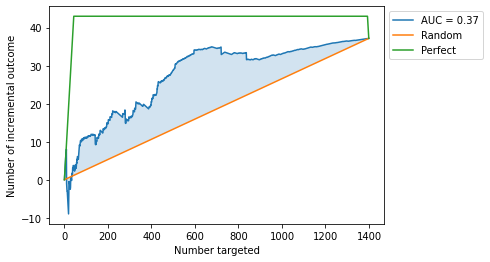

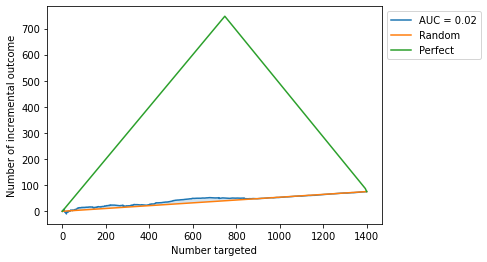

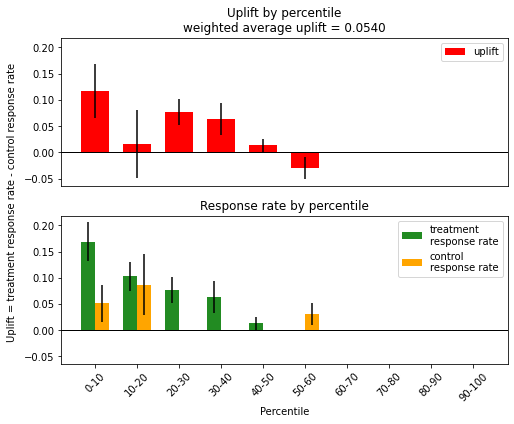

In [ ]:
ul_ = model.predict([pairTest_to_pred,t_to_pred,labelTest_to_pred,y_to_pred])



ul_ = utils.clean_list( ul_[0].copy() )


data = {'y_to_pred': y_to_pred, 'uplift': ul_ , 'treatment':t_to_pred}
data = pd.DataFrame(data)  

qini = qini_auc_score(y_true=data['y_to_pred'], uplift=data['uplift'], treatment=data['treatment'])
data.sort_values( by=['uplift'] )
plot_qini_curve(y_true=data['y_to_pred'], uplift=data['uplift'], treatment=data['treatment'])
plot_uplift_curve(y_true=data['y_to_pred'], uplift=data['uplift'], treatment=data['treatment'])
plot_uplift_by_percentile(y_true=data['y_to_pred'], uplift=data['uplift'], treatment=data['treatment'],kind='bar')


In [ ]:
data.shape

(1399, 3)

In [ ]:
print(qini)

-0.19584385935569423
